In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import balance

In [2]:
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


/tmp/ipykernel_23789/2633109205.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(table), cmap='hot', interpolation='nearest')


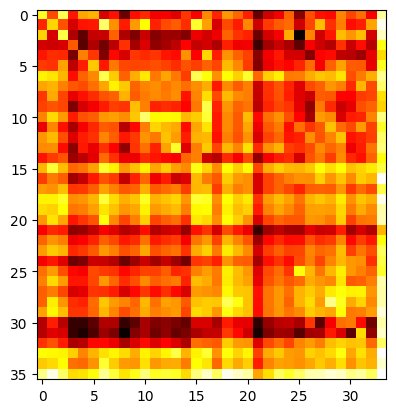

In [3]:
table = tables[14]
plt.imshow(np.log(table), cmap='hot', interpolation='nearest')
plt.show()

In [4]:
import jax.numpy as jnp
import jax
import timeit

key = jax.random.PRNGKey(1)
rho = jax.random.uniform(key, (34,), minval=0.1, maxval = 10)
W, W0 = balance.get_W(table, rho)

In [5]:
cost_f = jax.jit(lambda p: balance.CES(p, W, rho[:-1]))
s = jnp.array([1,1,1])
p = balance.get_prices(cost_f, 33, s)
p

Array([0.06450681, 0.15998966, 0.11960812, 0.00871357, 0.00602781,
       0.01326834, 0.1862526 , 0.05300972, 0.02101451, 0.01652198,
       0.08539043, 0.0242748 , 0.02087109, 0.06472377, 0.00393908,
       0.1323207 , 0.29906332, 0.01472658, 0.21564966, 0.07481477,
       0.07715265, 0.00113719, 0.00583097, 0.0163858 , 0.0101117 ,
       0.02881034, 0.05835357, 0.06127214, 0.13282923, 0.10413314,
       0.03540679, 0.01614466, 0.03366338, 1.        , 1.        ,
       1.        ], dtype=float32)

In [6]:
table_ = jnp.zeros((36,34))
table_ = table.at[:,:-1].set(balance.JCES(p, W, rho[:-1]))
table_ = table.at[:,-1].set(balance.JCES(p, W0, rho[-1:])) 
# N.B это пропорции, а не полное потребление

In [7]:
from ortools.linear_solver import pywraplp

def primal_J(Z, Z_hat):
    n, m = Z.shape
    n, m = m - 1, n - m + 1
    solver = pywraplp.Solver.CreateSolver("GLOP")
    u = [[solver.NumVar(0, solver.infinity(), 'u^'+str(i+1)+'_'+str(j)) for j in range(n+1)] for i in range(n+m)]
    x = [solver.NumVar(0, solver.infinity(), 'x_'+str(j)) for j in range(n+1)]
    for i in range(n+m):
        for j in range(n+1):
            solver.Add(u[i][j] >= float(Z_hat[i,j]) - float(Z[i,j]) * x[j])
            solver.Add(u[i][j] >= float(Z[i,j]) * x[j] - float(Z_hat[i,j]))
    for i in range(n):
        solver.Add(sum([float(Z[i,j]) * x[j] for j in range(n+1)]) == sum([float(Z[j,i]) for j in range(n+m)]) * x[i])
    solver.Minimize(sum([sum(u[i]) for i in range(n+m)]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print('optimal')
    return solver.Objective().Value(), jnp.array([x[j].solution_value() for j in range(n+1)])

In [8]:
J, x = primal_J(table_, table)

optimal


In [9]:
print(J)

2670042.1309686652


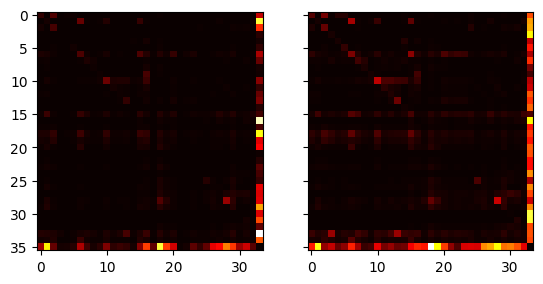

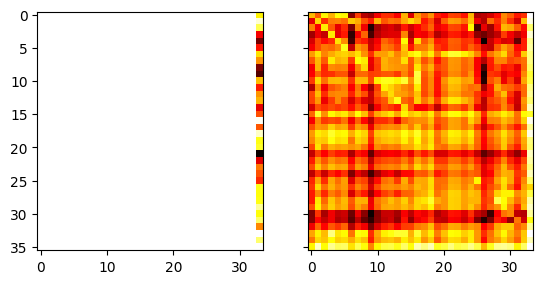

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(table, cmap='hot', interpolation='nearest')
ax2.imshow(x * table_, cmap='hot', interpolation='nearest')
f, (ax3, ax4) = plt.subplots(1, 2, sharey=True)
ax3.imshow(jnp.log(jnp.abs(table - table_)), cmap='hot', interpolation='nearest')
ax4.imshow(jnp.log(jnp.abs(table - x * table_)), cmap='hot', interpolation='nearest')

In [11]:
jnp.sum(jnp.abs(table - table_)), jnp.sum(jnp.abs(table - x * table_))

(Array(2232510.8, dtype=float32), Array(2670042., dtype=float32))

In [12]:
a, b = table[:,-1], table_[:,-1]
print(a - jnp.dot(a,b)/jnp.dot(b,b) * b)

[ -5700.6562 100411.73    10216.453  -97353.016  -34969.86   -44997.906
  21266.996  -30753.002  -18822.41    -8760.891    6735.328  -28443.945
 -39200.137  -23938.059  -65183.492    5265.949  110699.95   -36602.984
 112508.555   18312.387   12095.672  -68621.39   -46523.49   -28521.96
 -63811.47   -19082.027   -5358.5156   4312.3594  33779.8     61077.42
 -44814.227   -4817.117  -38896.68   163665.12    48232.766       0.    ]


Почему-то вектор потребления __НЕ__ воспроизводится

Видимо воспроизводятся только отрасли, а конечное потребление, ведь оно однозначно будет этим задаваться

Перепишу что есть, чтоб не использовало вектор конечного потребления. А функции полезности конечных потребителей восстанавливать как доп-член в ошибку.